<a href="https://colab.research.google.com/github/PtrShi/cvr_course/blob/main/notebooks/cv_hw3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

In [1]:
!git clone https://github.com/PtrShi/cvr_course.git
# очищенный код из cv_hw3.ipynb

Cloning into 'cvr_course'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 281 (delta 76), reused 0 (delta 0), pack-reused 167
Receiving objects: 100% (281/281), 49.46 MiB | 36.51 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [2]:
import numpy as np
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

In [3]:
def order_points(pts):
    center_X, center_Y = np.mean(pts[:,0]) , np.mean(pts[:,1])
    center = (center_X, center_Y)
    shifted = pts - center
    theta = np.arctan2 (shifted[:, 1], shifted[:, 0])
    ind = np.argsort(theta)
    ordered = np.array (pts[ind], dtype = 'float32')

    if len (ordered) != 4:
      return (np.array ([(0,0), (150,0), (150,150), (0,150)],dtype = 'float32') , (int (75),int (75)))
    (tl, tr, br, bl) = ordered

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    x = int (max(widthA, widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    y = int (max(heightA, heightB))
   
    return ordered, (x, y)

In [4]:
def get_arrow_direction (img_orig):
  img_bw = cv2.cvtColor (img_orig, cv2.COLOR_BGR2GRAY)
  low_th  = (210) #, 200, 200)
  high_th = (255) #, 255, 255)
  mask = cv2.inRange (img_bw, low_th, high_th)

  contours, _ = cv2.findContours (mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  j = 1 
  ind_largest_cont = 0 
  while j < len (contours):
    if len (contours [j]) > len (contours [ind_largest_cont]):
      ind_largest_cont = j
    j = j + 1
  cnt = contours [ind_largest_cont]
  cnt_hull = cv2.convexHull (cnt)
  epsilon = 0.05 * cv2.arcLength (cnt_hull, True)
  vertices = cv2.approxPolyDP (cnt_hull, epsilon, True)

  vertices_norm = vertices [:,0,:]
  rect, unwarped_size = order_points (vertices_norm)

  dst = np.array([[0, 0], [unwarped_size[0], 0], [unwarped_size[0], unwarped_size[1]], [0, unwarped_size[1]]], dtype="float32")
  mx = cv2.getPerspectiveTransform (rect, dst) 
  mask_unwarped = cv2.warpPerspective (mask, mx, unwarped_size)

  crop_x, crop_y = 7, 7
  mask_unwarped_cropped = mask_unwarped [crop_y:-crop_y, crop_x:-crop_x]
  white = np.full ((mask_unwarped_cropped.shape [0], mask_unwarped_cropped.shape [1]), 255)
  mask_unwarped_cropped = white - mask_unwarped_cropped
  mask_unwarped_cropped = cv2.inRange (mask_unwarped_cropped, 1, 255)

  contours_unwarped, _ = cv2.findContours (mask_unwarped_cropped, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  j = 1 
  ind_largest_cont = 0 
    while j < len (contours_unwarped):
    if len (contours_unwarped [j]) > len (contours_unwarped [ind_largest_cont]):
      ind_largest_cont = j
    j = j + 1

  cnt_arrow = contours_unwarped [ind_largest_cont]

  box_x, box_y, box_w, box_h = cv2.boundingRect (cnt_arrow)
  cx = int (box_x + box_w / 2)
  cy = int (box_y + box_h / 2)

  weight_tl = np.count_nonzero (mask_unwarped_cropped [box_y:cy, box_x:cx])
  weight_tr = np.count_nonzero (mask_unwarped_cropped [box_y:cy, cx:cx + int (box_w/2)])
  weight_br = np.count_nonzero (mask_unwarped_cropped [cy: cy + int (box_h/2), cx:cx + int (box_w/2)])
  weight_bl = np.count_nonzero (mask_unwarped_cropped [cy: cy + int (box_h/2), box_x:cx])
  weights = np.array ((weight_tl, weight_tr, weight_bl, weight_br), dtype = 'int')
  first, second = np.argsort (-weights) [:2]
  summa = first + second
  if summa == 1:
    direction = 'up'
  else:
    if summa == 4:
      direction = 'right'
    else:
      if summa == 5:
        direction = 'down'
      else:
        if summa == 2:
          direction = 'left'
        else:
          direction = 'unknown'
  return direction


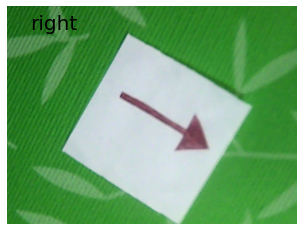

In [8]:
file = 'cvr_course/data/imgs/3.mov'
vid = cv2.VideoCapture (file)
while(vid.isOpened()): 
      
  ret, frame = vid.read() 
  if ret == True: 
    direction = get_arrow_direction (frame)
    plt.text (50, 50, direction, fontsize=20)
    plt.imshow (frame)  
    plt.axis ('off')
    plt.show ()    
    clear_output (wait = True)    
  else:  
    break
